**Additional PS: Decision Making**

Planning Algorithms in AI

Kashirin Aleksandr

Skoltech 2021

**Problem Description: Escape the Maze**

In this problem set you are asked to play the game of Escape the Maze. The environment is a simple 2d grid world with some obstacles. In this game, there are two players, one is the evader (yellow dot) who wants to escape the maze by reaching the goal state. The second player, the pursuer (green dot) who wants to catch the evader.

**Task 1: Value Iteration**

In this task, you will calculate the optimal policy for the evader to move. For now, the pursuer remains static.

In [1]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
from utils import plot_joint_enviroment, action_space, transition_function, pursuer_transition
from vi import vi
import matplotlib.animation as animation
import random
#%matplotlib widget

# Control flags
labelsize = 14
titlesize = 16
suptitlesize = 18

Visualization of the workspace

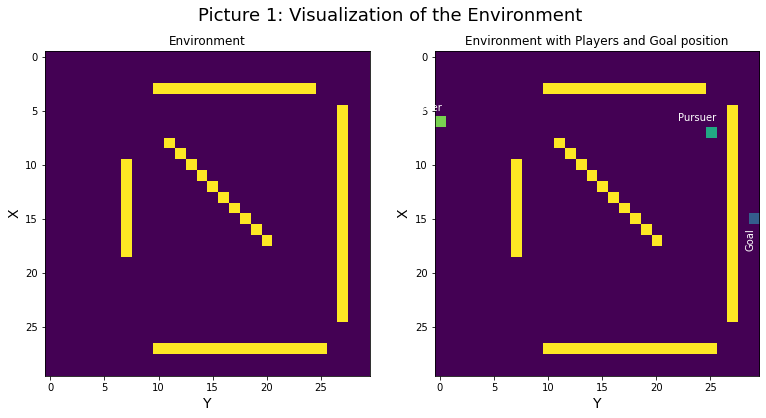

In [2]:
# Load the data
data = np.load("data_ps3.npz")
environment = data['environment']

# Plot the environment
plt.figure(figsize=[6.4*2, 6])
plt.suptitle('Picture 1: Visualization of the Environment', fontsize=suptitlesize)

# Plot the environment
plt.subplot(1, 2, 1)
plt.imshow(environment)
plt.title('Environment')
plt.xlabel('Y', fontsize=labelsize)
plt.ylabel('X', fontsize=labelsize)

# Define goal state and initial state
X_evader = (6, 0)
X_pursuer = (7, 25)
X_goal = (15, 29)

# Plot the Environment with goal and initial states
plt.subplot(1, 2, 2)
im = plot_joint_enviroment(environment, X_evader, X_pursuer, X_goal)
plt.imshow(im)
plt.title('Environment with Players and Goal position')
plt.text(X_evader[1] - 3, X_evader[0] - 1, "Evader", c='white')
plt.text(X_pursuer[1] - 3, X_pursuer[0] - 1, "Pursuer", c='white')
plt.text(X_goal[1], X_goal[0] + 3, "Goal", c='white', rotation='vertical', rotation_mode='anchor')
plt.xlabel('Y', fontsize=labelsize)
plt.ylabel('X', fontsize=labelsize)

plt.show()

**A: Enumerate the action space. The coordinates of actions are u = (row; column).**

In [3]:
action_names = ['Up', 'Left', 'Down', 'Right']
for i in range(len(action_space)):
    print(action_names[i], ":", action_space[i])

# Define dictionary with action names and spaces
actions = dict(zip(action_space, action_names))

Up : (-1, 0)
Left : (0, -1)
Down : (1, 0)
Right : (0, 1)


**B. Formulate the optimal cost-to-go G∗ in recursive form**

$G_k^* = min_{u_k}(l(x_k, u_k) + G_{k+1}^*(f(x_k, u_k)))$

**C. Implement the VI algorithm for infinite length sequences. To show this, you are asked to include a picture of the final G∗**

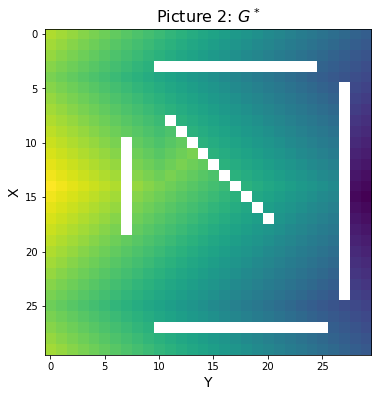

In [4]:
def implement_value_iteration(env, goal, N=100, action_space=action_space):
    """ Function returns a 2D matrix with cost-to-go to the desired goal position
    
    Args:
        env - The grid environment
        goal - The goal state
        N - Limit of iterations for the while cycle
        action_space - Space of possible actions for the entity
        
    Returns:
        G - 2D matrix with cost-to-go to the desired goal position
    """
    # Initialize action cost
    action_cost = 1
    # Initialize G graph
    G = np.zeros(env.shape)
    G[:] = np.inf
    G[goal] = 0
    # Initialize counter
    counter = 0
    # Initialize flag of G change
    flag = True
    # While there is a change in G graph
    while flag == True:
        # If the G graph was not changed
        if flag == False:
            # Then break the cycle
            break
        # If counter reached it is limit
        if counter == N:
            # Then break the cycle
            break
        # Increment the counter
        counter += 1
        # Set flag to False
        flag = False
        # Calculate G
        # For each X, Y
        for x in range(env.shape[0]):
            for y in range(env.shape[1]):
                # Check if G[X,Y] != inf
                if G[x, y] != np.inf:
                    # Assign the state
                    state = (x, y)
                    # For each action
                    for action in action_space:
                        # Calculate new state
                        new_state, is_action = transition_function(env, state, action)
                        # If action is possible
                        if is_action:
                            # Than compare current cost in the cell of new_state 
                            # with the cost of previous state + action cost
                            G[new_state] = min(G[new_state], G[state] + action_cost)
                            # Set flag True, as we modified G matrix
                            flag = True
    return G

G_star = implement_value_iteration(environment, X_goal)

# Plot the Heatmap of the matrix
plt.figure(figsize=[6.4, 6])
plt.imshow(G_star)
plt.title(r'Picture 2: $G^*$', fontsize=titlesize)
plt.xlabel('Y', fontsize=labelsize)
plt.ylabel('X', fontsize=labelsize)
plt.show()

In [5]:
def implement_policy_VI(G, env=environment, actions=actions, action_space=action_space):
    """ Function calculate a policy for cost-to-go 2d-matrix

    Args:
        G - 2D matrix with cost-to-go to the desired goal position
        env - Environment workspace
        actions - Dictionary with possible actions and coordinates {coordinates:name}

    Returns:
        policy - 2D matrix with names of actions to perform towards goal state
    """
    # Initialize policy matrix
    policy = np.chararray(G.shape, itemsize=5)
    # For each cell in cost-to-go matrix
    for x in range(G.shape[0]):
        for y in range(G.shape[1]):
            # Assign the current state
            state = (x, y)
            # For each action
            for action in action_space:
                # Calculate new state
                new_state, is_action = transition_function(env, state, action)
                # If action is possible
                if is_action:
                    # Than check if the value in the state is more
                    # then in the new_state
                    if G[state] > G[new_state]:
                        # Calculate differences between states
                        diff = tuple(np.array(new_state) - np.array(state))
                        # Pick the name of the movement from actions dictionary
                        # and assign the name of this movement to cell of policy table
                        policy[state] = actions[diff]
                        # if we already changed the cell, than omit other actions
                        break
    return policy

P = implement_policy_VI(G_star)

In [6]:
# Define functions to calculate plan
def get_plan(X_init, X_goal, policy, actions=actions):
    """ Function returns plan according to the obtained policy

    Args:
        X_init - Initial state
        X_goal - Goal state
        policy - Obtained policy
        actions - Dictionary with possible actions and coordinates {coordinates:name}

    Returns:
        plan - Path plan
    """
    # Invert actions dictionary
    inverted_actions = {name:coordinates for coordinates, name in actions.items()}
    # Initialize plan
    plan = []
    # Initialize first state
    state = X_init
    # While we have not reached the goal state
    while state != X_goal:
        # If we are reached the goal state
        if state == X_goal:
            # Break the cycle
            break
        # Append node in the plan
        plan.append(state)
        # Get the direction in the policy of the current state
        direction = policy[state].decode('ascii')
        # Get the coordinates according to the inverted dictionary
        coordinates = inverted_actions[direction]
        # Get the new state
        state = tuple(np.array(state) + np.array(coordinates))
    # Append the last state
    plan.append(X_goal)
    return plan

plan = get_plan(X_evader, X_goal, P)

MovieWriter ffmpeg unavailable; using Pillow instead.


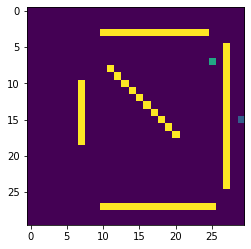

In [7]:
# Visualization of the algorithm
fig = plt.figure()
imgs = []
for X in plan:
    im = plot_joint_enviroment(environment, X, X_pursuer, X_goal)
    plot = plt.imshow(im)
    imgs.append([plot])

ani = animation.ArtistAnimation(fig, imgs, interval=100, blit=True)
ani.save('plan_vi.gif')
plt.show()

**C: Un-comment the pursuer transition function. Did you escape?**

MovieWriter ffmpeg unavailable; using Pillow instead.


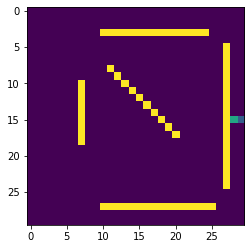

In [8]:
# Visualization of the algorithm
fig = plt.figure()
imgs = []
pursuer_state = X_pursuer
for X in plan:
    pursuer_state = pursuer_transition(environment, X, pursuer_state)
    im = plot_joint_enviroment(environment, X, pursuer_state, X_goal)
    plot = plt.imshow(im)
    imgs.append([plot])

ani = animation.ArtistAnimation(fig, imgs, interval=200, blit=True)
ani.save('plan_purs.gif')
plt.show()

**Comment: No, I did not escape.**

**Task 2: Monte Carlo Tree Search**

Pursuer at (7, 24)
Evader at (6, 1)
Pursuer at (7, 23)
Evader at (6, 2)
Pursuer at (7, 22)
Evader at (6, 3)
Pursuer at (6, 22)
Evader at (6, 4)
Pursuer at (6, 21)
Evader at (5, 4)
Pursuer at (6, 20)
Evader at (5, 5)
Pursuer at (6, 19)
Evader at (5, 6)
Pursuer at (6, 18)
Evader at (5, 7)
Pursuer at (6, 17)
Evader at (5, 8)
Pursuer at (6, 16)
Evader at (5, 9)
Pursuer at (6, 15)
Evader at (5, 10)
Pursuer at (6, 14)
Evader at (5, 11)
Pursuer at (6, 13)
Evader at (5, 12)
Pursuer at (6, 12)
Evader at (5, 13)
Pursuer at (6, 13)
Evader at (5, 14)
Pursuer at (6, 14)
Evader at (5, 15)
Pursuer at (5, 14)
Evader at (5, 16)
Pursuer at (5, 15)
Evader at (5, 17)
Pursuer at (5, 16)
Evader at (4, 17)
Pursuer at (5, 17)
Evader at (4, 18)
Pursuer at (4, 17)
Evader at (4, 19)
Pursuer at (4, 18)
Evader at (4, 20)
Pursuer at (4, 19)
Evader at (4, 21)
Pursuer at (4, 20)
Evader at (4, 22)
Pursuer at (4, 21)
Evader at (4, 23)
Pursuer at (4, 22)
Evader at (4, 24)
Pursuer at (4, 23)
Evader at (4, 25)
Pursuer at 

MovieWriter ffmpeg unavailable; using Pillow instead.


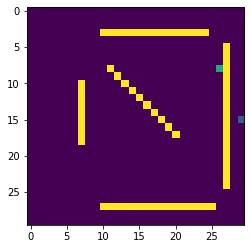

In [9]:
# Invert actions dictionary
inverted_actions = {name:coordinates for coordinates, name in actions.items()}

def get_distance(A, B, type="man"):
    """ Function returns Manhattan or Euclid distance between two vectors

    Args:
        A - Vector A: (x, y)
        B - Vector B: (x, y)
        type - Type of return distance: ("man" or "euc")
    Returns:
        distance - Manhattan or Euclid distance between vectors
    """
    if type == "man":
        distance = np.abs(B[0] - A[0]) + np.abs(B[1] - A[1])
    elif type == "euc":
        a = np.abs(B[0] - A[0])
        b = np.abs(B[1] - A[1])
        distance = np.sqrt(a^2 + b^2)
    return distance


def simulate_MCTS(env, X_evader, X_pursuer, X_goal, default_policy, s=100):
    """ Function returns reward for the node

    Args:
        env - The grid environment
        X_evader - Initial position for the evader
        X_pursuer - Initial position for the pursuer
        X_goal - Goal state for the evader
        default_policy - Value Iteration policy for the evader
        s - Maximum amount of steps in simulation

    Returns:
        reward - Node reward
    """
    # Initialize reward
    reward = 0

    for i in range(s):
        # Make a pursuer move
        X_pursuer = pursuer_transition(env, X_evader, X_pursuer)
        # If Pursuer cathes Evader
        if X_pursuer == X_evader:
            # Defeat, reward = 0
            return 0
        # Get the action from the obtained policy
        direction = default_policy[X_evader].decode('ascii')
        U_evader = inverted_actions[direction]
        # Calculate evader new state
        X_evader, _ = transition_function(env, X_evader, U_evader)
        # If Evader reached the goal state
        if X_evader == X_goal:
            reward += 100 - (i + 1)
            return reward
        # If nothing happened
        reward += 0.1 / get_distance(X_evader, X_goal)


def get_action_MCTS(env, X_evader, X_pursuer, X_goal, default_policy, action_space=action_space):
    """ Function returns optimal action for the evader in order to reach 
        the Value Iteration policy with help of the
        Monte Carlo Tree Search (MCTS) algorithm

    Description:
        MCTS has four states:
            Expansion - makes potential move for the current node
            Simulation - does given amount of simulations from the expanded node
            Update - counts amount of [win/simulation] and updates this number for all parent nodes
            Selection - selects the most promising node and then starts the algorithm again
        
        For more information: https://www.youtube.com/watch?v=Fbs4lnGLS8M&ab_channel=FullstackAcademy

    Args:
        env - The grid environment
        X_evader - Initial position for the evader
        X_pursuer - Initial position for the pursuer
        X_goal - Goal state for the evader
        default_policy - Value Iteration policy for the evader
        action_space - List of tuples of possible actions

    Returns:
        U_evader - Optimal action for the evader
    """
    # Initialize current position of the evader
    evader_state = X_evader
    # Initialize current position of the pursuer
    pursuer_state = X_pursuer
    # Initialize max reward
    max_reward = 0
    # Initialize return move
    U_evader = None

    # For each action in action space
    for action in action_space:
        X_evader = evader_state
        X_pursuer = pursuer_state
        # Calculate evader new state
        X_evader, is_action = transition_function(env, X_evader, action)
        # Check if evader reached the goal state
        if X_evader == X_goal:
            # Return final action
            return action
        # Check if action is possible and evader was not caught
        if is_action and (X_evader != X_pursuer):
            # Simulate reward
            reward = simulate_MCTS(env, X_evader, X_pursuer, X_goal, default_policy)
            # Check if this reward higher than max reward
            if reward >= max_reward:
                # Reassign max reward
                max_reward = reward
                # Set action move
                U_evader = action

    # If all actions are below zero
    if U_evader == None:
        # Than make a random move
        rand = np.random.randint(0, 3)
        U_evader = action_space[rand]
    
    U = U_evader
    return U

# Game algorithm
# Assign the policy from Value Iteration algorithm
policy_VI = implement_policy_VI(G_star)
# Invert actions dictionary
inverted_actions = {name:coordinates for coordinates, name in actions.items()}
# Initialize figure
fig = plt.figure()
# Initialize list of images to create an animation
imgs = []
for s in range(300):
    # Get the matrix of current joint environment
    im = plot_joint_enviroment(environment, X_evader, X_pursuer, X_goal)
    # Plot the joint environment
    plot = plt.imshow(im)
    # Append image to the image list to create an animation
    imgs.append([plot])
    # Propagate the pursuer state
    X_pursuer = pursuer_transition(environment, X_evader, X_pursuer)
    print('Pursuer at {}'.format(X_pursuer))
    # If pursuer cathes the evader
    if X_pursuer == X_evader:
        print('Game over!')
        # Break the game
        break
    # Get the action from the obtained policy
    direction = policy_VI[X_evader].decode('ascii')
    U_evader = inverted_actions[direction]
    # Get the action with MCTS algorithm
    U_evader = get_action_MCTS(environment, X_evader, X_pursuer, X_goal, policy_VI)
    X_evader, _ = transition_function(environment, X_evader, U_evader)
    print('Evader at {}'.format(X_evader))
    # If evader reached the goal state
    if X_evader == X_goal:
        print('The evader has successfully escaped')
        # Then win and break the game
        break

# Get the matrix of the last win or lose movement
im = plot_joint_enviroment(environment, X_evader, X_pursuer, X_goal)
# Plot the joint environment
plot = plt.imshow(im)
# Append image to the image list to create an animation
imgs.append([plot])
# Create animation
ani = animation.ArtistAnimation(fig, imgs, interval=100, blit=True)
# Save animation
ani.save('scape_solve.gif')
# Show plot
plt.show()